# Setup

## Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from os import chdir, mkdir, getcwd, listdir
from os.path import join
import requests
from zipfile import ZipFile
import matplotlib.pyplot as plt
import time
import pickle

In [2]:
HOME = getcwd()

## Download dataset

### FAR Part 121

In [3]:
filepath = join(HOME, 'Regulations', 'FAR_Part121_nodes_labelled.xlsx')
df_FAA = pd.read_excel(filepath)[['title', 'requirement', 'label', 'tag']]
df_FAA

,title,requirement,label,tag
0,§ 121.1(a),§ 121.1 Applicability.\nThis part prescribes...,0,title only
1,§ 121.1(b),§ 121.1 Applicability.\nThis part prescribes...,0,title only
2,§ 121.1(c),§ 121.1 Applicability.\nThis part prescribes...,0,title only
3,§ 121.1(d)(1),§ 121.1 Applicability.\nThis part prescribes...,0,title only
4,§ 121.1(d)(2),§ 121.1 Applicability.\nThis part prescribes...,0,title only
...,...,...,...,...
2354,§ 121.1500(b)(3),§ 121.1500 SFAR No. 111 - Lavatory Oxygen Sy...,2,operator
2355,§ 121.1500(b)(4),§ 121.1500 SFAR No. 111 - Lavatory Oxygen Sy...,2,operator
2356,§ 121.1500(b)(5),§ 121.1500 SFAR No. 111 - Lavatory Oxygen Sy...,2,operator
2357,§ 121.1500(c),§ 121.1500 SFAR No. 111 - Lavatory Oxygen Sy...,2,operator


In [4]:
df_FAA.groupby('tag').agg({'tag':'count'})

,tag
tag,
aircraft,769
operator,1376
title only,214


### RBAC 121

In [5]:
#################### 
#filepath = join(HOME, 'Regulations', 'RBAC121_sections.xlsx')
#filepath = join(HOME, 'Regulations', 'RBAC121_nodes_labelled.xlsx')
#df_ANAC = pd.read_excel(filepath)[['title', 'requirement', 'label', 'tag']]

In [6]:
#df_ANAC.groupby('tag').agg({'tag':'count'})

## Create and fit tokenizer

In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(df_FAA.requirement.to_list())
#tokenizer.fit_on_texts(df_ANAC.requirement.to_list())

dict_size = len(tokenizer.word_index)

print('Dictionary size: {}'.format(dict_size))
print('Word examples: ', end='')
print(list(tokenizer.word_index)[:100])

Dictionary size: 4845
Word examples: ['<OOV>', 'the', 'of', 'and', 'a', 'in', '121', 'to', '§', 'or', 'for', 'this', 'flight', 'that', 'airplane', 'is', 'an', 'certificate', 'may', 'section', 'must', 'be', 'by', 'each', 'as', 'with', 'holder', 'training', 'b', 'paragraph', 'required', 'operations', 'person', 'at', 'following', 'requirements', 'no', 'part', '1', 'any', 'under', 'data', 'on', 'airplanes', 'c', 'are', 'unless', 'not', 'approved', '2', 'equipment', 'pilot', 'engine', 'it', 'aircraft', 'except', 'passenger', 'if', 'from', 'type', 'program', 'provided', 'd', 'more', 'use', 'after', 'than', 'all', 'maintenance', 'emergency', 'information', 'one', 'system', 'operate', 'airport', 'recorders', 'time', 'category', 'powered', 'shall', 'which', 'limitations', 'operating', 'has', '3', 'i', 'crewmember', 'digital', 'administrator', 'specified', 'least', 'other', 'e', 'transport', 'include', 'command', 'chapter', 'operation', 'hours', 'applicable']


## Download GloVe

In [8]:
URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
chdir(HOME)

if 'GloVe' not in listdir():
    mkdir('GloVe')

chdir(join(HOME, 'GloVe'))

if 'glove.6B.300d.txt' not in listdir():
    r = requests.get(URL)
    with open('glove.6B.zip', 'wb') as file:
        file.write(r.content)
    zipfile = ZipFile('glove.6B.zip')
    zipfile.extractall()
    
chdir(HOME)

## Create embedding matrix

In [9]:
chdir(HOME)

keys, vectors = [], []

with open(join(HOME, 'GloVe', 'glove.6B.300d.txt'), encoding='utf-8') as file:
    for line in file:
        key, vector = line.split(' ', maxsplit=1)
        vector = np.array(vector.split(' ')).astype('float')
        keys.append(key)
        vectors.append(vector)

embedding_dict = dict(zip(keys, vectors))

In [10]:
embedding_dim = 300
embedding_matrix = np.zeros((dict_size+1, embedding_dim))

print('Words without available embedding:')
for pos, key in enumerate(tokenizer.word_index.keys()):
    if key in embedding_dict.keys():
        embedding_matrix[pos,:] = embedding_dict[key]
    else:
        print(key, end=', ')

Words without available embedding:
<OOV>, §, holder's, §§, aqp, nontransport, “when, installed”, flightcrew, operator's, ewis, turbopropeller, °c, airplane's, utlitize, fstd, nonturbine, manufacturer's, “no, 344a, reseating, “conditions, icing”, “e”, smoking”, pilot's, crewmember's, redispatch, “d”, nonpressurized, person's, “b”, pdsc, rffs, “a”, govinfo, observer's, vso2, 422b, “c”, passenger's, dfdr, 422a, belt”, microlamberts, pretakeoff, series6048, clearway, child's, “fasten, airsep, sequal, wv050, fimm, sr422b, “seat, “this, dfdau, fdau, lrns, lrcs, 119b, 119a, 04a, engineer's, fstds, individual's, inogen, lifechoice, 41104, applicant's, notice”, “training, provider”, provider's, h25, flugtechnische, illyushin, 96t, stopways, adr's, 079, sr422, placarded, “on”, “off”, aircraft”, sideward, member's, crewmembers', nondimming, altitude”, sd3, c124a, tso's, c74b, c74c, c112, c151, c123a, ifsds, ifsd, 380a, dispatcher's, ffss, redispatching, inspector's, evaluator's, physician's, 0040

## Prepare dataset object

In [11]:
y = np.array(df_FAA.label)
x = df_FAA.requirement.map(lambda x: x.split('  ')[1])
x = np.array(x)
x = tokenizer.texts_to_sequences(x)

#y_valid = np.array(df_ANAC.label)
#x_valid = df_ANAC.requirement
#x_valid = np.array(x_valid)
#x_valid = tokenizer.texts_to_sequences(x_valid)

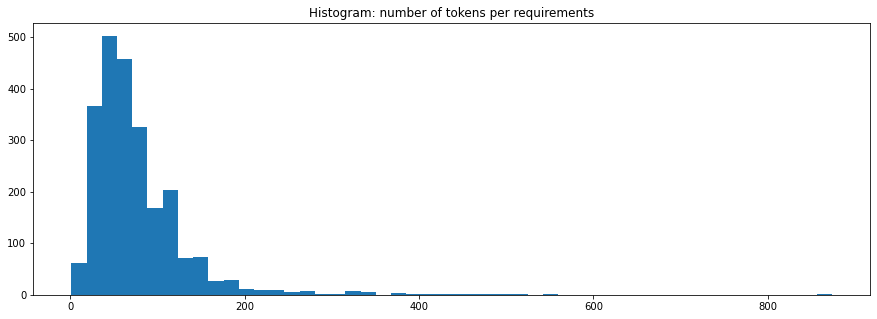

In [12]:
plt.figure(figsize = (15,5))
plt.hist(np.array([len(seq) for seq in x]), 50)
plt.title('Histogram: number of tokens per requirements')
plt.show()

In [13]:
sequence_length = 200

x = tf.keras.preprocessing.sequence.pad_sequences(x,maxlen=sequence_length, truncating='pre', padding='pre')
x = np.array(x)

#x_valid = tf.keras.preprocessing.sequence.pad_sequences(x_valid,maxlen=sequence_length, truncating='pre', padding='pre')
#x_valid = np.array(x_valid)

In [14]:
x = tf.data.Dataset.from_tensor_slices(x)
#x = tf.data.Dataset.from_tensor_slices(np.zeros((y.shape[0], sequence_length))) # uncomment to test with null input
y = tf.data.Dataset.from_tensor_slices(y)
dataset = tf.data.Dataset.zip((x,y)).shuffle(buffer_size = 200, seed=20210413)

#x_valid = tf.data.Dataset.from_tensor_slices(x_valid)
#y_valid = tf.data.Dataset.from_tensor_slices(y_valid)
#valid = tf.data.Dataset.zip((x_valid, y_valid))

# Build model

In [15]:
# hyperparameters
h = {'epochs' : 100,
     'learning_rate' : .01,
     'batch_size' : 256,
     'recurrent_units' : 64,
     'dropout' : .20,
     'recurrent_dropout' : .05,
     'reduce_lr_factor' : 0.2,
     'reduce_lr_patience' : 10,
     'early_stopping_patience' : 20}

verbose = 1

In [16]:
model = tf.keras.models.Sequential(name = 'Bidirectional_GRU_Softmax')

# add embedding layer
model.add(tf.keras.layers.Embedding(input_dim = dict_size + 1,
                                    output_dim = embedding_dim,
                                    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                                    input_shape = [sequence_length],
                                    trainable = False,
                                    name = "GloVe_6B_300D"))

# add recurrent layer
model.add(tf.keras.layers.GRU(h['recurrent_units'],
                              dropout = h['dropout'],
                              recurrent_dropout = h['recurrent_dropout'],
                              return_sequences = False,
                              name = "GRU"))

# add dense output layer
model.add(tf.keras.layers.Dense(3, 'softmax', name = 'Softmax'))

# create callbacks
cb_plateau = tf.keras.callbacks.ReduceLROnPlateau(factor = h['reduce_lr_factor'], 
                                                  patience = h['reduce_lr_patience'],
                                                  min_lr = h['learning_rate'] / 100,
                                                  verbose = 1)
cb_stopping = tf.keras.callbacks.EarlyStopping(patience = h['early_stopping_patience'],
                                               restore_best_weights = True,
                                               monitor = 'val_sparse_categorical_accuracy',
                                               verbose = 1)

# compile model
model.compile(optimizer = tf.keras.optimizers.Nadam(h['learning_rate']),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])
model.summary()

Model: "Bidirectional_GRU_Softmax"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GloVe_6B_300D (Embedding)    (None, 200, 300)          1453800   
_________________________________________________________________
GRU (GRU)                    (None, 64)                70272     
_________________________________________________________________
Softmax (Dense)              (None, 3)                 195       
Total params: 1,524,267
Trainable params: 70,467
Non-trainable params: 1,453,800
_________________________________________________________________


In [17]:
#history = model.fit(dataset.batch(h['batch_size']),
#                    epochs = h['epochs'],
#                    verbose = verbose)
                    #validation_data = valid.batch(1),
                    #callbacks = [cb_plateau, cb_stopping]) # ADD WHEN VALIDATION SET AVAILABLE
        
history = model.fit(dataset.batch(h['batch_size']),
                    epochs = h['epochs'],
                    verbose = verbose,
                    callbacks = tf.keras.callbacks.EarlyStopping(monitor='sparse_categorical_accuracy',
                                                                 patience = 5, min_delta = .01))
                    #callbacks = [cb_plateau, cb_stopping]) # ADD WHEN VALIDATION SET AVAILABLE        

Epoch 1/100
10/10 [==============================] - 15s 2s/step - loss: 0.8012 - sparse_categorical_accuracy: 0.6918
Epoch 2/100
10/10 [==============================] - 14s 1s/step - loss: 0.8252 - sparse_categorical_accuracy: 0.6685
Epoch 3/100
10/10 [==============================] - 14s 1s/step - loss: 0.8441 - sparse_categorical_accuracy: 0.6647
Epoch 4/100
10/10 [==============================] - 14s 1s/step - loss: 0.8103 - sparse_categorical_accuracy: 0.6681
Epoch 5/100
10/10 [==============================] - 14s 1s/step - loss: 0.7291 - sparse_categorical_accuracy: 0.6990
Epoch 6/100
10/10 [==============================] - 14s 1s/step - loss: 0.6714 - sparse_categorical_accuracy: 0.7334
Epoch 7/100
10/10 [==============================] - 14s 1s/step - loss: 0.5705 - sparse_categorical_accuracy: 0.7770
Epoch 8/100
10/10 [==============================] - 15s 1s/step - loss: 0.4811 - sparse_categorical_accuracy: 0.8148
Epoch 9/100
10/10 [==============================] - 14s

In [18]:
loss, accuracy = model.evaluate(dataset.batch(128), verbose=0)
loss = np.round(loss, 6)
accuracy = np.round(accuracy, 3)
certainty = np.round(np.exp(-loss), 3)

#val_loss, val_accuracy = model.evaluate(valid.batch(1), verbose=0)
#val_loss = np.round(val_loss, 6)
#val_accuracy = np.round(val_accuracy, 3)
#val_certainty = np.round(np.exp(-val_loss), 3)

#print("Model performance:")
#print("Loss (train | valid): {} | {}".format(loss, val_loss))
#print("Accuracy (train | valid): {} | {}".format(accuracy, val_accuracy))

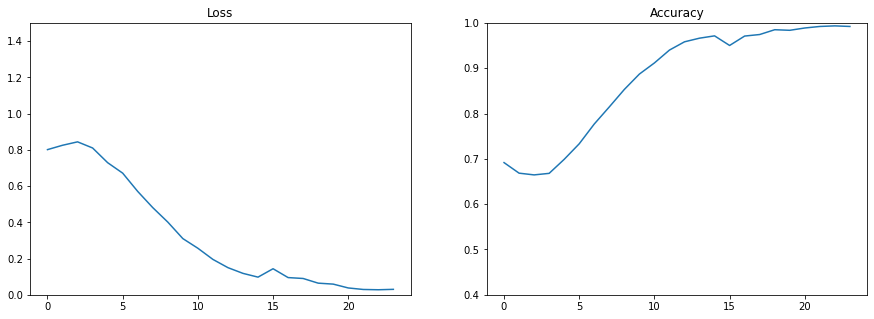

In [19]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylim((0,1.5))

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.ylim((.4,1))

plt.show()

In [20]:
chdir(HOME)

timestamp = time.strftime('%Y-%m-%d_%H-%M-%S')
model_filename = 'model___' + timestamp + '___' + model.name + '.h5'
tokenizer_filename = 'tokenizer___' + timestamp + '.h5'

if 'models' not in listdir():
    mkdir('models')

model.save(join(HOME, 'models', model_filename))

with open(join(HOME, 'models', tokenizer_filename), 'wb') as file:
    pickle.dump(tokenizer, file)
    
# load with:
#with open(join(HOME, 'models', tokenizer_filename), 'rb') as file:
#    tk_load = pickle.load(file)